#ECE 1508 Final Project: Text Translation using YouTube Video Transcripts (Group 33) Test Space

### Library Imports and Project Macros

In [ ]:
!pip install youtube-transcript-api
!git clone https://github.com/artetxem/vecmap.git
!pip install transformers
!pip install torch
!pip install torch torchvision
!pip install pandas
!pip install torchmetrics
!pip install nltk rouge

Cloning into 'vecmap'...
remote: Enumerating objects: 104, done.
remote: Total 104 (delta 0), reused 0 (delta 0), pack-reused 104
Receiving objects: 100% (104/104), 72.59 KiB | 3.30 MiB/s, done.
Resolving deltas: 100% (57/57), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import re
import os
import csv
import nltk
import h5py
import string
import time
import numpy as np
from numpy import array, argmax, random, take
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torch.nn.functional import dropout, relu, softmax, log_softmax
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils import clip_grad_norm_

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from keras.models import Sequential,Model
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras import optimizers
from keras.layers import Input, LSTM, Dense, Embedding,RepeatVector, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model

from transformers import BertTokenizer, EncoderDecoderModel, BertModel
from transformers import MarianTokenizer, MarianMTModel
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from youtube_transcript_api import YouTubeTranscriptApi
from youtube_transcript_api._errors import NoTranscriptFound
from torchmetrics.text import BLEUScore
from nltk.tokenize import word_tokenize
from torch.utils.data import random_split
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
from rouge import Rouge

nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

###Data Preprocessing

In [ ]:
def merge_transcript_texts(transcript_list):
  # Initialize an empty string to store the merged subtitle text
  merged_text = ''

  # Iterate through the provided list of subtitles
  for item in transcript_list:
  # Extract the 'text' value from each dictionary and append it to the merged_text string
  # A space is used here to separate each subtitle segment for readability
   merged_text += item['text'] + ' '

  # Return the merged subtitle text
  return merged_text.strip()  # Use strip() to remove the trailing space

In [ ]:
def load_data(path):
    """
    Load dataset
    """
    input_file = os.path.join(path)
    with open(input_file, "r") as f:
        data = f.read()

    return data.split('\n')

#english_sentences = load_data('/content/small_vocab_en.txt')

#french_sentences = load_data('/content/small_vocab_fr.txt')

In [ ]:
# https://www.youtube.com/watch?v=laod4t3woeU
# video id is the part in watch?v=..... in youtube url
# collect 10 video as the test
# Data fetch and clean

def get_transcript_en_fr(video_id):
  # video_id = 'laod4t3woeU'
  try:
      transcript_list = YouTubeTranscriptApi.list_transcripts(video_id)
      # Fetch the transcript language
      transcript = transcript_list.find_transcript(['en'])
      fr_transcript = transcript_list.find_transcript(['fr'])
      # Fetching the actual transcript data
      transcript_data = transcript.fetch()
      fr_transcript_data = fr_transcript.fetch()

      merged_transcript_data = ''
      fr_merged_transcript_data = ''

      for entry in transcript_data:
        merged_transcript_data += entry['text'] + " "

      for fr_entry in fr_transcript_data:
        fr_merged_transcript_data += fr_entry['text'] + " "

      merged_transcript_data = merged_transcript_data.replace("\n", " ")
      merged_transcript_data = merged_transcript_data.lower()
      fr_merged_transcript_data = fr_merged_transcript_data.replace("\n", " ")
      fr_merged_transcript_data = fr_merged_transcript_data.lower()

      sentences = re.split(r'[.!?] +', merged_transcript_data)
      fr_sentences = re.split(r'[.!?] +', fr_merged_transcript_data)
      # sentences = fr_merged_transcript_data.split(r'[.!?] +', res)
      print(sentences)
      print(fr_sentences)
      return sentences, fr_sentences

  except Exception as e:
      print(f"An error occurred: {e}")

In [ ]:
video_id_list = ['laod4t3woeU', 'QbzrVpIpSIE', 'D-hLh63iuSI', 'ver3Cg_tMEE', 'D7a7BHaY8-Q','uW9mcG0rdLY','vN_6jfIoYE4','J-uCOLXnzq0','0lo8sAEXPHw','-mEC57qp5fQ']

#video_id_list = ['laod4t3woeU']
# Find the file in the content/..
all_sentences = []
all_fr_sentences = []
for video_id in video_id_list:
  sentences, fr_sentences = get_transcript_en_fr(video_id)
  print(len(sentences))
  print(len(fr_sentences))
  all_sentences += sentences
  all_fr_sentences += fr_sentences
  # filename = f'en_{video_id}_sentence.csv'
  # fr_filename = f'fr_{video_id}_sentence.csv'

  # with open(filename, mode='w', newline='') as file:
  #     writer = csv.writer(file)
  #     writer.writerows(sentences)

  # with open(fr_filename, mode='w', newline='') as file:
  #     writer = csv.writer(file)
  #     writer.writerows(fr_sentences)

  with open('en.txt', 'w') as file:
      for item in all_sentences:
          file.write("%s\n" % item)

  with open('fr.txt', 'w') as file:
      for item in all_fr_sentences:
          file.write("%s\n" % item)

train_sentences, temp_sentences, train_fr_sentences, temp_fr_sentences = train_test_split(
    all_sentences, all_fr_sentences, test_size=0.2, random_state=42)

valid_sentences, test_sentences, valid_fr_sentences, test_fr_sentences = train_test_split(
    temp_sentences, temp_fr_sentences, test_size=0.5, random_state=42)  # 0.25 x 0.8 = 0.2


['and laugh at their antics', 'their behavior makes us happy, sad and sometimes scared', 'but do they know emotions', 'do they feel love, fear, sadness and anger', 'until recently it was difficult to study that', 'but thanks to new developments in neuroscience now can', 'for centuries man considered animals as lower life forms', 'a kind of robots that steered by instincts and hormones', 'philosophers believed that as biological machines responded', 'they hardly differed from a table or chair', "they weren't even up to capable of the simplest feelings", 'that prejudice grew into a dogma', "scientists didn't want to be accused of anthropomorphism", 'animal human traits attribute', 'so people were the only thinking beings', 'and animals functioned on their instincts', 'in the past, a scientist this chase like this: zebras experience a stimulus leading to flight behaviour', 'today scientists look open-minded towards animals', 'it is now taken into account that zebras flee out of fear', 'pu

In [ ]:
def preprocess_and_tokenize(data):
    data = re.sub(r'[^\w\s]', '', data)
    data = re.sub(r'\s+', ' ', data).strip()
    tokens = word_tokenize(data.lower())
    return tokens

# padding
def pad(x, length=None):
  return pad_sequences(x, maxlen=length, padding='post')

def logits_to_sentence(logits, tokenizer):
    id_to_word = {id: word for word, id in tokenizer.word_index.items()}
    id_to_word[0] = '<PAD>'
    out = ' '.join(id_to_word[np.argmax(logit)] for logit in logits).replace('<PAD>', '').strip()
    return out

def build_vocab(sentences):
    tokenizer = Tokenizer(filters='')
    tokenizer.fit_on_texts(sentences)
    return tokenizer

def print_vocab(tokenizer):
    word_index = tokenizer.word_index
    for word, index in word_index.items():
        print(f"{word}: {index}")

def prepare_translation_data(english_sentences, french_sentences):

    english_tokens = [preprocess_and_tokenize(sentence) for sentence in english_sentences]
    french_tokens = [preprocess_and_tokenize(sentence) for sentence in french_sentences]

    english_vocab = build_vocab([' '.join(tokens) for tokens in english_tokens])
    french_vocab = build_vocab([' '.join(tokens) for tokens in french_tokens])

    english_sequences = english_vocab.texts_to_sequences([' '.join(tokens) for tokens in english_tokens])
    french_sequences = french_vocab.texts_to_sequences([' '.join(tokens) for tokens in french_tokens])


    max_eng_seq_length = max([len(seq) for seq in english_sequences])
    max_fr_seq_length = max([len(seq) for seq in french_sequences])

    print(f"Max encoder sequence length: {max_eng_seq_length}")
    print(f"Max decoder sequence length: {max_fr_seq_length}")

    return english_tokens, french_tokens, english_vocab, french_vocab, english_sequences, french_sequences, max_eng_seq_length, max_fr_seq_length


english_tokens, french_tokens, english_vocab, french_vocab, english_sequences, french_sequences, max_eng_seq_length, max_fr_seq_length=prepare_translation_data(train_sentences, train_fr_sentences)


padded_tokens_en = pad(english_sequences)
padded_tokens_fr = pad(french_sequences)


print("English vocabulary size:", len(english_vocab.word_index))
print("French vocabulary size:", len(french_vocab.word_index))
print("First English sentence:", sentences[0])
print("First English sentence tokens:", english_sequences[0])
print("First French sentence:", fr_sentences[0])
print("First French sentence tokens:", french_sequences[0])

Max encoder sequence length: 49
Max decoder sequence length: 57
English vocabulary size: 4981
French vocabulary size: 5855
First English sentence: when the winter world disappears, and the sun's rays begin to gather strength, it's the start of a season that is a law unto itself
First English sentence tokens: [42, 844, 4, 339]
First French sentence: quand le monde hivernal disparaît, et les rayons du soleil commencer à reprendre des forces, c'est le début d'une saison c'est une loi en soi
First French sentence tokens: [37, 1498, 93]


###General Toolbox

In [ ]:
def sentence_to_seq(sentence):
    tokens = preprocess_and_tokenize(sentence)
    sequence = [english_vocab.word_index.get(word, english_vocab.word_index.get("<UNK>")) for word in tokens]
    return sequence

def sentence_to_seq_fr(sentence):
    tokens = preprocess_and_tokenize(sentence)
    sequence = [french_vocab.word_index.get(word, french_vocab.word_index.get("<UNK>")) for word in tokens]
    return sequence


def predict_translation(model, sentence, english_tokenizer, french_tokenizer):
    model.eval()
    sequence = sentence_to_seq(sentence)
    sequence = [s for s in sequence if s is not None]
    sequence = pad_sequences([sequence], maxlen=20, padding='post')
    sequence = torch.from_numpy(sequence).to(device)

    with torch.no_grad():
        output = model(sequence)
        output_seq = torch.argmax(output.squeeze(0), dim=1).cpu().numpy()
        output_seq = np.array([a for a, b in zip(output_seq, np.r_[output_seq[1:], output_seq[-1]+1]) if a != b])
        output_seq = output_seq[output_seq != 2]
    translated_sentence = [french_vocab.index_word.get(index, '') for index in output_seq]
    return ' '.join(translated_sentence)

def model_evaluation(model, train_sentences, train_fr_sentences, valid_sentences, valid_fr_sentences):
    model.eval()
    total_bleu = 0
    b = 0
    result_train = 0
    result_valid = 0
    for test_sentence, test_fr_sentence in zip(train_sentences, train_fr_sentences):
        english_sentence = test_sentence
        predicted_french_sentence = predict_translation(model, english_sentence, english_tokens, french_tokens)

        a = sentence_bleu([test_fr_sentence], predicted_french_sentence)
        if a > 0.1:
          total_bleu += a
          b += 1
    if b != 0:
        result_train = total_bleu / b

    total_bleu = 0
    b = 0
    for test_sentence, test_fr_sentence in zip(valid_sentences, valid_fr_sentences):
        english_sentence = test_sentence
        predicted_french_sentence = predict_translation(model, english_sentence, english_tokens, french_tokens)

        a = sentence_bleu([test_fr_sentence], predicted_french_sentence)
        if a > 0.1:
          total_bleu += a
          b += 1
    if b != 0:
        result_valid = total_bleu / b

    return result_train, result_valid

def model_plot(epochs, train_losses, train_bleu_scores, valid_bleu_scores):
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Time')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, train_bleu_scores, label='Training BLEU Score')
    plt.xlabel('Epochs')
    plt.ylabel('BLEU Score')
    plt.title('Training BLEU Score Over Time')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, valid_bleu_scores, label='Validation BLEU Score')
    plt.xlabel('Epochs')
    plt.ylabel('BLEU Score')
    plt.title('Validation BLEU Score Over Time')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def train_model(model, dataloader, loss_fn, optimizer, epochs, device):
    model.train()
    train_losses = []
    train_bleu_scores = []
    valid_bleu_scores = []
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (input_data, target_data) in enumerate(dataloader):
            input_data, target_data = input_data.to(device), target_data.to(device).long()

            output = model(input_data)

            loss = loss_fn(output.view(-1, output.shape[-1]), target_data.view(-1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            train_bleu, valid_bleu = model_evaluation(model, train_sentences, train_fr_sentences, valid_sentences, valid_fr_sentences)
        avg_loss = total_loss / len(dataloader)
        train_losses.append(avg_loss)
        train_bleu_scores.append(train_bleu)
        valid_bleu_scores.append(valid_bleu)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss} - Train Bleu: {train_bleu} - Valid Bleu: {valid_bleu}")
    model_plot(epochs, train_losses, train_bleu_scores, valid_bleu_scores)
    print("Training complete.")
    return model, train_losses, train_bleu_scores, valid_bleu_scores

In [ ]:
device = ""
if torch.cuda.is_available():
    device = "cuda"
elif torch.has_mps:
    device = "mps"
else:
    device = "cpu"
# device = "cpu"

training_en_x = pad(padded_tokens_en, padded_tokens_fr.shape[1])
training_en_x_aligned = training_en_x[:len(padded_tokens_fr)]

print(len(training_en_x))
print(len(padded_tokens_fr))

dataset = TensorDataset(torch.from_numpy(training_en_x), torch.from_numpy(padded_tokens_fr))
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

2630
2630


<ipython-input-10-d930c064e842>:4: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  elif torch.has_mps:


###LSTM RNN

In [ ]:
class LSTM_RNN(nn.Module):
    def __init__(self, input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
        super(LSTM_RNN, self).__init__()
        self.input_shape = input_shape
        self.output_sequence_length = output_sequence_length
        self.english_vocab_size = english_vocab_size
        self.french_vocab_size = french_vocab_size

        # Embedding layer remains the same
        self.embedding = nn.Embedding(num_embeddings=english_vocab_size + 1, embedding_dim=256)

        # Replace nn.RNN with nn.LSTM
        self.RecUnit = self.RecUnit = nn.LSTM(input_size = 256, hidden_size=256, num_layers=3, batch_first=True, bidirectional=True)

        # Other layers remain unchanged
        self.time_distributed1 = nn.Linear(in_features=512, out_features=1024)
        self.dropout = nn.Dropout(p= 0.5)
        self.time_distributed2 = nn.Linear(in_features=1024, out_features=french_vocab_size + 1)

    def forward(self, x):
        x = self.embedding(x)  # Embedding step is unchanged
        x, (hidden, cell) = self.RecUnit(x)  # LSTM returns hidden and cell states
        x = self.time_distributed1(x)
        x = relu(x)
        x = self.dropout(x)
        x = self.time_distributed2(x)
        x = log_softmax(x, dim=2)
        return x


Number of Layers: 1 (hidden size 256), Unidirectional

Epoch 1/100 - Loss: 2.3892696386291865 - Train Bleu: 0.14817489034890652 - Valid Bleu: 0.11909900438187945
Epoch 2/100 - Loss: 1.4191951411111015 - Train Bleu: 0.17797782431896125 - Valid Bleu: 0.18479575820253874
Epoch 3/100 - Loss: 1.3016075179690407 - Train Bleu: 0.17562917661987798 - Valid Bleu: 0.18586838098932812
Epoch 4/100 - Loss: 1.2314374021121435 - Train Bleu: 0.1850876763573375 - Valid Bleu: 0.18987928179544658
Epoch 5/100 - Loss: 1.1547304845991588 - Train Bleu: 0.19626594033285183 - Valid Bleu: 0.19948966348900746
Epoch 6/100 - Loss: 1.0762374855223156 - Train Bleu: 0.2234820743319663 - Valid Bleu: 0.2162505306211237
Epoch 7/100 - Loss: 0.9749769043354761 - Train Bleu: 0.25794714709321187 - Valid Bleu: 0.24412452689244526
Epoch 8/100 - Loss: 0.875113274369921 - Train Bleu: 0.3057604528358716 - Valid Bleu: 0.25994354103710987
Epoch 9/100 - Loss: 0.7509302425952185 - Train Bleu: 0.41034330530378854 - Valid Bleu: 0.27941146812089124
Epoch 10/100 - Loss: 0.6376290598085949 - 

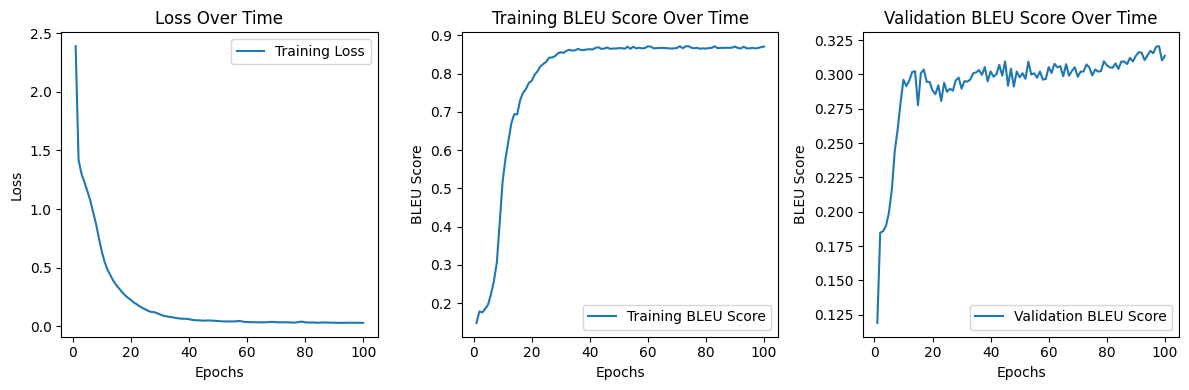

Training complete.


In [ ]:
LSTM_RNN_model = LSTM_RNN(training_en_x.shape, len(training_en_x), len(english_vocab.word_index), len(french_vocab.word_index))
LSTM_RNN_model.to(device)
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(LSTM_RNN_model.parameters(), lr=0.001)
train_model(LSTM_RNN_model, dataloader, loss_fn, optimizer, 100, device)
torch.save(LSTM_RNN_model.state_dict(), 'LSTM_RNN_model.pth')

Number of Layers: 1 (hidden size 256), Bidirectional

Epoch 1/100 - Loss: 2.2116885639372326 - Train Bleu: 0.19759524106838847 - Valid Bleu: 0
Epoch 2/100 - Loss: 1.4214846264748346 - Train Bleu: 0.17006013091299702 - Valid Bleu: 0.17842805636054557
Epoch 3/100 - Loss: 1.3405486884571256 - Train Bleu: 0.17332273816867816 - Valid Bleu: 0.17013349251633572
Epoch 4/100 - Loss: 1.25651292573838 - Train Bleu: 0.18684570051714733 - Valid Bleu: 0.17846838458704595
Epoch 5/100 - Loss: 1.1876619316282726 - Train Bleu: 0.1938752377545254 - Valid Bleu: 0.19189301420357738
Epoch 6/100 - Loss: 1.1039360534577143 - Train Bleu: 0.2119428811383451 - Valid Bleu: 0.20417309296043218
Epoch 7/100 - Loss: 1.0077007838657923 - Train Bleu: 0.24059748095660274 - Valid Bleu: 0.2289837106211771
Epoch 8/100 - Loss: 0.8974548180898031 - Train Bleu: 0.2857717486634235 - Valid Bleu: 0.25164297180989026
Epoch 9/100 - Loss: 0.7861098831608182 - Train Bleu: 0.36795340488717154 - Valid Bleu: 0.26337368988249016
Epoch 10/100 - Loss: 0.6628561984925043 - Train Bleu: 0.46269

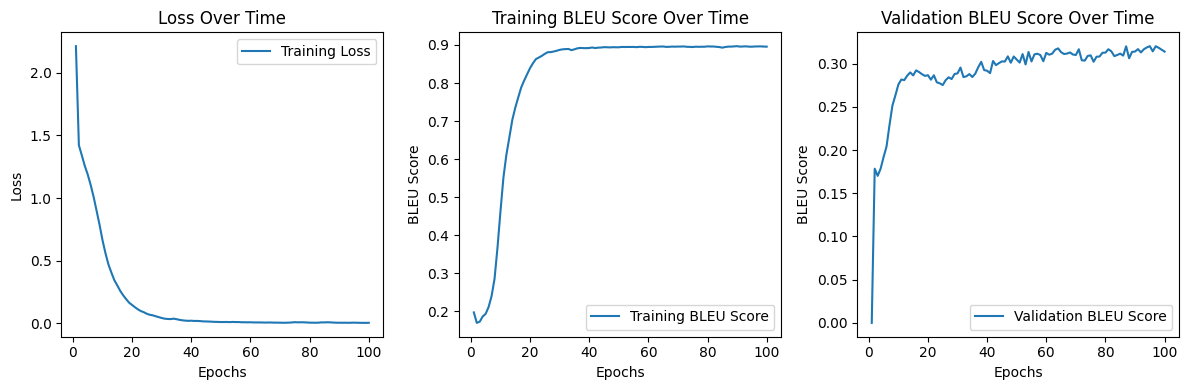

Training complete.


In [ ]:
LSTM_RNN_model = LSTM_RNN(training_en_x.shape, len(training_en_x), len(english_vocab.word_index), len(french_vocab.word_index))
LSTM_RNN_model.to(device)
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(LSTM_RNN_model.parameters(), lr=0.001)
train_model(LSTM_RNN_model, dataloader, loss_fn, optimizer, 100, device)
torch.save(LSTM_RNN_model.state_dict(), 'LSTM_RNN_model.pth')

Number of Layers: 1 (hidden size 512), Bidirectional

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Epoch 1/100 - Loss: 2.026207895505996 - Train Bleu: 0 - Valid Bleu: 0
Epoch 2/100 - Loss: 1.4191236950102306 - Train Bleu: 0.1518365139336412 - Valid Bleu: 0.14401855670468736
Epoch 3/100 - Loss: 1.3484218574705578 - Train Bleu: 0.17025124105368955 - Valid Bleu: 0.15849474227800056
Epoch 4/100 - Loss: 1.2918219566345215 - Train Bleu: 0.1756418241719713 - Valid Bleu: 0.16411121539616516
Epoch 5/100 - Loss: 1.2212945889858973 - Train Bleu: 0.18836540866738646 - Valid Bleu: 0.17967155322661738
Epoch 6/100 - Loss: 1.144659997451873 - Train Bleu: 0.2023961321636412 - Valid Bleu: 0.18767688852065217
Epoch 7/100 - Loss: 1.0610861011913844 - Train Bleu: 0.2232144859162134 - Valid Bleu: 0.19692059875826204
Epoch 8/100 - Loss: 0.9581956168015798 - Train Bleu: 0.2526630181845654 - Valid Bleu: 0.21011544078208688
Epoch 9/100 - Loss: 0.8366784510158357 - Train Bleu: 0.2980076981422843 - Valid Bleu: 0.23608108396895028
Epoch 10/100 - Loss: 0.710768251192002 - Train Bleu: 0.40484550064611247 - Valid 

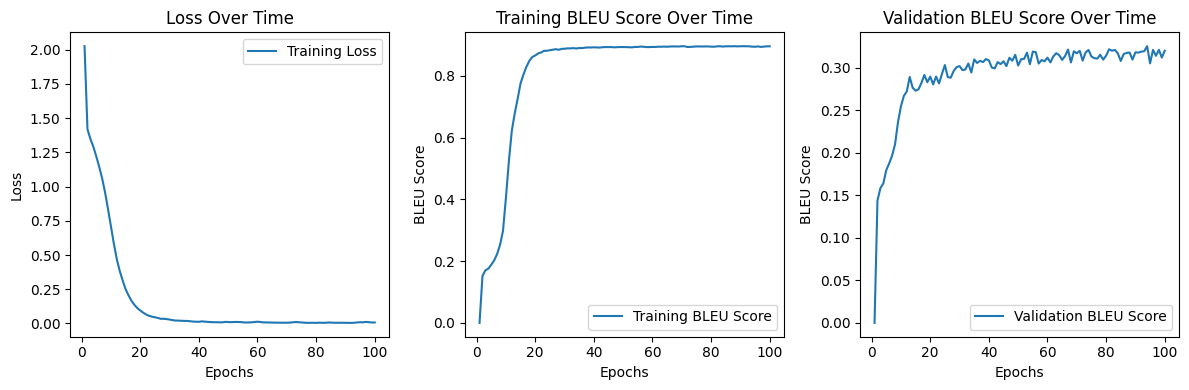

Training complete.


In [ ]:
LSTM_RNN_model = LSTM_RNN(training_en_x.shape, len(training_en_x), len(english_vocab.word_index), len(french_vocab.word_index))
LSTM_RNN_model.to(device)
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(LSTM_RNN_model.parameters(), lr=0.001)
train_model(LSTM_RNN_model, dataloader, loss_fn, optimizer, 100, device)
torch.save(LSTM_RNN_model.state_dict(), 'LSTM_RNN_model.pth')

Number of Layers: 2 (hidden size 512), Bidirectional

Epoch 1/100 - Loss: 2.024729092915853 - Train Bleu: 0 - Valid Bleu: 0
Epoch 2/100 - Loss: 1.437752102102552 - Train Bleu: 0 - Valid Bleu: 0
Epoch 3/100 - Loss: 1.4038855745678855 - Train Bleu: 0 - Valid Bleu: 0
Epoch 4/100 - Loss: 1.3594243639991397 - Train Bleu: 0.1574478525075122 - Valid Bleu: 0.16930331782009878
Epoch 5/100 - Loss: 1.3082692509605771 - Train Bleu: 0.17432415934865947 - Valid Bleu: 0.16917035109803025
Epoch 6/100 - Loss: 1.2412428997811817 - Train Bleu: 0.16965131852250198 - Valid Bleu: 0.1707564770765749
Epoch 7/100 - Loss: 1.1777671930335818 - Train Bleu: 0.1732164006762362 - Valid Bleu: 0.17553643892923762
Epoch 8/100 - Loss: 1.117813066357658 - Train Bleu: 0.18336107480609 - Valid Bleu: 0.17652603460117472
Epoch 9/100 - Loss: 1.0157896124181294 - Train Bleu: 0.20005301582341736 - Valid Bleu: 0.1849527957389765
Epoch 10/100 - Loss: 0.9270068932147253 - Train Bleu: 0.2297001474727245 - Valid Bleu: 0.18916786325242593
Epoch 11/100 - Loss: 0.8321391968500047 - Train 

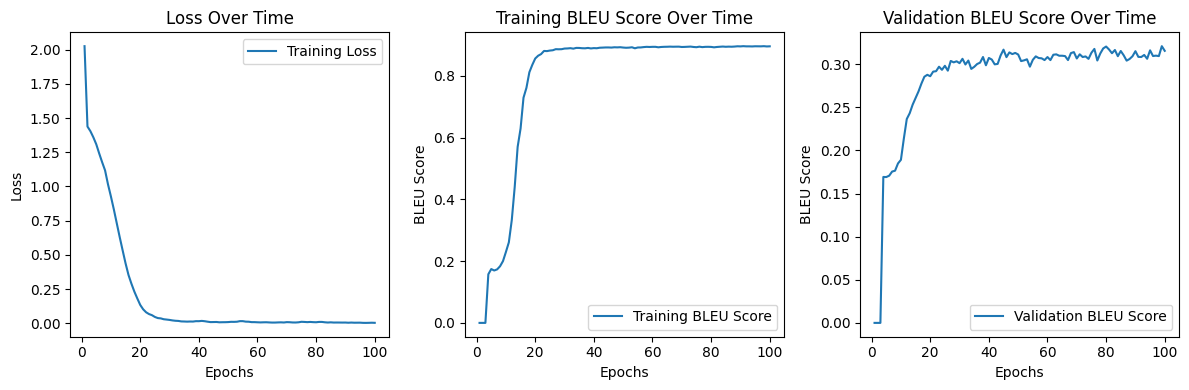

Training complete.


In [ ]:
LSTM_RNN_model = LSTM_RNN(training_en_x.shape, len(training_en_x), len(english_vocab.word_index), len(french_vocab.word_index))
LSTM_RNN_model.to(device)
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(LSTM_RNN_model.parameters(), lr=0.001)
train_model(LSTM_RNN_model, dataloader, loss_fn, optimizer, 100, device)
torch.save(LSTM_RNN_model.state_dict(), 'LSTM_RNN_model.pth')

Number of Layers: 3 (hidden size 512), Bidirectional

Epoch 1/100 - Loss: 2.0468022425969443 - Train Bleu: 0 - Valid Bleu: 0
Epoch 2/100 - Loss: 1.445418119430542 - Train Bleu: 0 - Valid Bleu: 0
Epoch 3/100 - Loss: 1.4243121090389432 - Train Bleu: 0.12636692760130933 - Valid Bleu: 0
Epoch 4/100 - Loss: 1.387108998639243 - Train Bleu: 0.12267873882266618 - Valid Bleu: 0
Epoch 5/100 - Loss: 1.337531050046285 - Train Bleu: 0.14824074644129043 - Valid Bleu: 0.16486793079898665
Epoch 6/100 - Loss: 1.2782424546423412 - Train Bleu: 0.16633487106823436 - Valid Bleu: 0.17692984749858354
Epoch 7/100 - Loss: 1.2146224067324685 - Train Bleu: 0.17130927345599134 - Valid Bleu: 0.17462756772452787
Epoch 8/100 - Loss: 1.1474417817024958 - Train Bleu: 0.1811482691972699 - Valid Bleu: 0.1643482190191171
Epoch 9/100 - Loss: 1.0733999028092338 - Train Bleu: 0.18836022690714466 - Valid Bleu: 0.17545674831778468
Epoch 10/100 - Loss: 0.9905883499554226 - Train Bleu: 0.20366827199936746 - Valid Bleu: 0.18420222795589924
Epoch 11/100 - Loss: 0.9153321399575188 - 

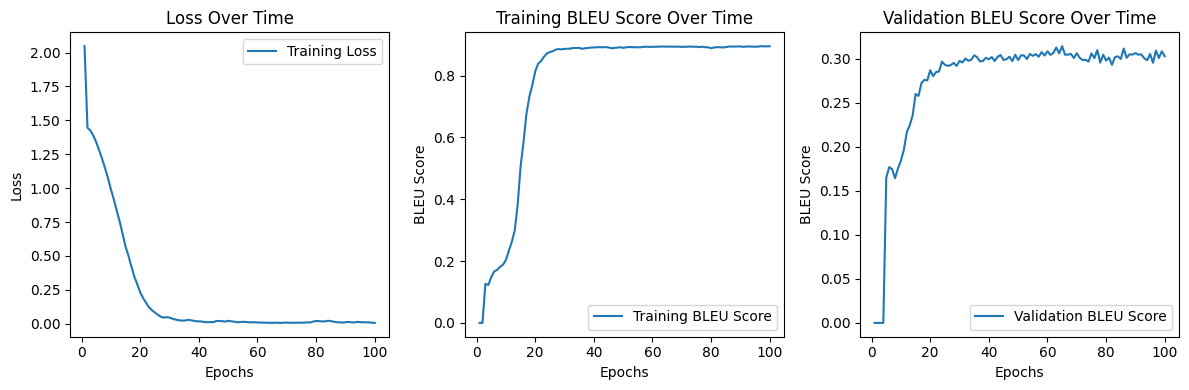

Training complete.


In [ ]:
LSTM_RNN_model = LSTM_RNN(training_en_x.shape, len(training_en_x), len(english_vocab.word_index), len(french_vocab.word_index))
LSTM_RNN_model.to(device)
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(LSTM_RNN_model.parameters(), lr=0.001)
train_model(LSTM_RNN_model, dataloader, loss_fn, optimizer, 100, device)
torch.save(LSTM_RNN_model.state_dict(), 'LSTM_RNN_model.pth')